In [1]:
import numpy as np
import colorsys
import h5py
from PIL import Image
import io
import b3d
import matplotlib.pyplot as plt
import time
import os
%matplotlib inline

In [2]:
# paths for reading physion metadata
physion_assets_path = os.path.join(
    b3d.get_root_path(),
    "assets/physion/",)

# stim_name = 'lf_0/dominoes_all_movies/pilot_dominoes_0mid_d3chairs_o1plants_tdwroom_0012'
stim_name = '0000'

hdf5_file_path = os.path.join(physion_assets_path,
    f"{stim_name}.hdf5",
)

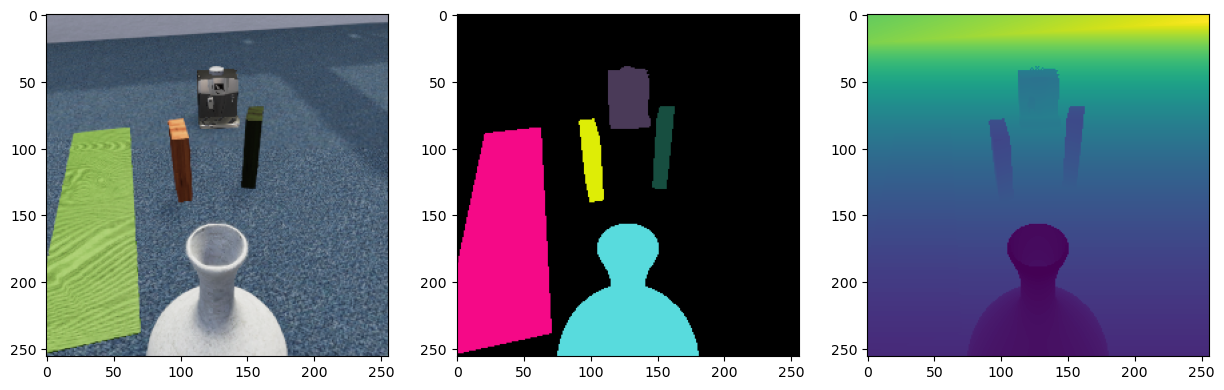

: 

In [6]:
h5file = h5py.File(hdf5_file_path, 'r')

im = np.array(Image.open(io.BytesIO(h5file['frames']['0000']['images']['_img_cam0'][:])))

im_seg = np.array(Image.open(io.BytesIO(h5file['frames']['0000']['images']['_id_cam0'][:])))
colors = h5file['static']['object_segmentation_colors'][:][0]

depth_map = np.array(h5file['frames']['0000']['images']['_depth_cam0'])
depth_map = np.flip(depth_map,0)

fig = plt.figure(figsize=[15, 5])
ax = fig.add_subplot(131)
ax.imshow(im)

ax = fig.add_subplot(132)
ax.imshow(im_seg)

ax = fig.add_subplot(133)
ax.imshow(depth_map)